In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
from string import ascii_uppercase
from operator import itemgetter

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import preprocessing
from sklearn import svm
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


##Preparing Data

In [ ]:
n2v = '/content/drive/MyDrive/IS/data/vecs_node2vec.csv'
dp = '/content/drive/MyDrive/IS/data/vecs_deepwalk.csv'
sdne = '/content/drive/MyDrive/IS/data/vecs_sdne.csv'
w2v = '/content/drive/MyDrive/IS/data/vecs_word2vec.csv'
gcn = '/content/drive/MyDrive/IS/data/vecs_gcn.csv'

df_emb = pd.read_csv(gcn)
df_emb.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,5.866775,5.963728,5.897037,5.897362,5.931007,6.005211,5.884931,5.985114,5.883612,...,5.921068,5.853966,5.849709,5.873781,5.882127,5.862492,5.966124,5.865399,5.896132,5.893132
1,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,3.413349,3.510301,3.443610,3.443936,3.477581,3.551785,3.431505,3.531687,3.430186,...,3.467642,3.400540,3.396282,3.420355,3.428701,3.409066,3.512697,3.411973,3.442706,3.439705
2,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,2.612311,2.709263,2.642572,2.642898,2.676543,2.750746,2.630466,2.730649,2.629148,...,2.666603,2.599501,2.595244,2.619316,2.627662,2.608027,2.711659,2.610934,2.641667,2.638667
3,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,3.442863,3.539815,3.473124,3.473450,3.507095,3.581299,3.461019,3.561201,3.459700,...,3.497155,3.430054,3.425796,3.449868,3.458214,3.438580,3.542211,3.441486,3.472220,3.469219
4,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,2.625600,2.722552,2.655861,2.656187,2.689831,2.764035,2.643755,2.743938,2.642437,...,2.679892,2.612790,2.608533,2.632605,2.640951,2.621316,2.724948,2.624223,2.654956,2.651956


In [ ]:
df_emb = df_emb.rename(columns = {'Unnamed: 0':'id'})
type(df_emb)

'''
df_emb = df_emb.set_index('id')
df_emb.head()
'''

"\ndf_emb = df_emb.set_index('id')\ndf_emb.head()\n"

In [ ]:
df_scam = pd.read_csv('/content/drive/MyDrive/IS/data/vecs_label.csv')
df_scam.head()

,Unnamed: 0,id,scam
0,0,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0
1,1,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1
2,2,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0
3,3,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0
4,4,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0


In [ ]:
df_scam = df_scam.drop(columns = ['Unnamed: 0'])
#df_scam = df_scam.set_index('id')
df_scam.head()

,id,scam
0,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0
1,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1
2,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0
3,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0
4,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0


Text(0.5, 1.0, 'Checking lmbalance')

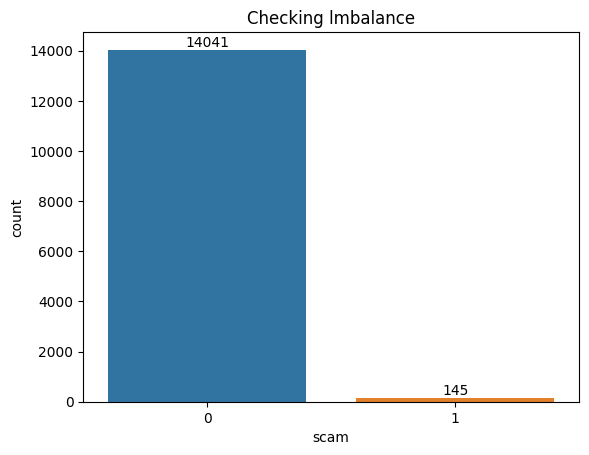

In [ ]:
chk = sns.countplot(data = df_scam, x = 'scam')

for container in chk.containers:
    chk.bar_label(container)

plt.title('Checking lmbalance')

In [ ]:
df_vecny = pd.merge(df_emb, df_scam, how = 'left', on = 'id')
df_vecny.head()

,id,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,scam
0,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,5.866775,5.963728,5.897037,5.897362,5.931007,6.005211,5.884931,5.985114,5.883612,...,5.853966,5.849709,5.873781,5.882127,5.862492,5.966124,5.865399,5.896132,5.893132,0
1,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,3.413349,3.510301,3.443610,3.443936,3.477581,3.551785,3.431505,3.531687,3.430186,...,3.400540,3.396282,3.420355,3.428701,3.409066,3.512697,3.411973,3.442706,3.439705,1
2,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,2.612311,2.709263,2.642572,2.642898,2.676543,2.750746,2.630466,2.730649,2.629148,...,2.599501,2.595244,2.619316,2.627662,2.608027,2.711659,2.610934,2.641667,2.638667,0
3,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,3.442863,3.539815,3.473124,3.473450,3.507095,3.581299,3.461019,3.561201,3.459700,...,3.430054,3.425796,3.449868,3.458214,3.438580,3.542211,3.441486,3.472220,3.469219,0
4,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,2.625600,2.722552,2.655861,2.656187,2.689831,2.764035,2.643755,2.743938,2.642437,...,2.612790,2.608533,2.632605,2.640951,2.621316,2.724948,2.624223,2.654956,2.651956,0


In [ ]:
df_n2v = df_vecny.set_index('id')
df_n2v.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,scam
id,,,,,,,,,,,,,,,,,,,,,
0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,5.866775,5.963728,5.897037,5.897362,5.931007,6.005211,5.884931,5.985114,5.883612,5.951544,...,5.853966,5.849709,5.873781,5.882127,5.862492,5.966124,5.865399,5.896132,5.893132,0
0x002f0c8119c16d310342d869ca8bf6ace34d9c39,3.413349,3.510301,3.443610,3.443936,3.477581,3.551785,3.431505,3.531687,3.430186,3.498117,...,3.400540,3.396282,3.420355,3.428701,3.409066,3.512697,3.411973,3.442706,3.439705,1
0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,2.612311,2.709263,2.642572,2.642898,2.676543,2.750746,2.630466,2.730649,2.629148,2.697079,...,2.599501,2.595244,2.619316,2.627662,2.608027,2.711659,2.610934,2.641667,2.638667,0
0xe892875b87b94c44edf0e91ee9f49d0525fadd83,3.442863,3.539815,3.473124,3.473450,3.507095,3.581299,3.461019,3.561201,3.459700,3.527631,...,3.430054,3.425796,3.449868,3.458214,3.438580,3.542211,3.441486,3.472220,3.469219,0
0x0681d8db095565fe8a346fa0277bffde9c0edbbf,2.625600,2.722552,2.655861,2.656187,2.689831,2.764035,2.643755,2.743938,2.642437,2.710368,...,2.612790,2.608533,2.632605,2.640951,2.621316,2.724948,2.624223,2.654956,2.651956,0


In [ ]:
df_n2v['scam'].head()

id
0x16f209b5332a1b4fa5bf19497ca40154c5db2f85    0
0x002f0c8119c16d310342d869ca8bf6ace34d9c39    1
0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b    0
0xe892875b87b94c44edf0e91ee9f49d0525fadd83    0
0x0681d8db095565fe8a346fa0277bffde9c0edbbf    0
Name: scam, dtype: int64

In [ ]:
x = np.array(df_n2v.drop(columns = ['scam']))
#x = preprocessing.normalize(x)

y = np.array(df_n2v['scam'])

In [ ]:
x_df = pd.DataFrame(x)
x_df.head(9000)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,5.866775,5.963728,5.897037,5.897362,5.931007,6.005211,5.884931,5.985114,5.883612,5.951544,...,5.921068,5.853966,5.849709,5.873781,5.882127,5.862492,5.966124,5.865399,5.896132,5.893132
1,3.413349,3.510301,3.443610,3.443936,3.477581,3.551785,3.431505,3.531687,3.430186,3.498117,...,3.467642,3.400540,3.396282,3.420355,3.428701,3.409066,3.512697,3.411973,3.442706,3.439705
2,2.612311,2.709263,2.642572,2.642898,2.676543,2.750746,2.630466,2.730649,2.629148,2.697079,...,2.666603,2.599501,2.595244,2.619316,2.627662,2.608027,2.711659,2.610934,2.641667,2.638667
3,3.442863,3.539815,3.473124,3.473450,3.507095,3.581299,3.461019,3.561201,3.459700,3.527631,...,3.497155,3.430054,3.425796,3.449868,3.458214,3.438580,3.542211,3.441486,3.472220,3.469219
4,2.625600,2.722552,2.655861,2.656187,2.689831,2.764035,2.643755,2.743938,2.642437,2.710368,...,2.679892,2.612790,2.608533,2.632605,2.640951,2.621316,2.724948,2.624223,2.654956,2.651956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,3.634415,3.731367,3.664676,3.665002,3.698647,3.772851,3.652570,3.752753,3.651252,3.719183,...,3.688707,3.621605,3.617348,3.641420,3.649766,3.630131,3.733763,3.633038,3.663771,3.660771
8996,3.634415,3.731367,3.664676,3.665002,3.698647,3.772851,3.652570,3.752753,3.651252,3.719183,...,3.688707,3.621605,3.617348,3.641420,3.649766,3.630131,3.733763,3.633038,3.663771,3.660771
8997,3.634415,3.731367,3.664676,3.665002,3.698647,3.772851,3.652570,3.752753,3.651252,3.719183,...,3.688707,3.621605,3.617348,3.641420,3.649766,3.630131,3.733763,3.633038,3.663771,3.660771
8998,3.634415,3.731367,3.664676,3.665002,3.698647,3.772851,3.652570,3.752753,3.651252,3.719183,...,3.688707,3.621605,3.617348,3.641420,3.649766,3.630131,3.733763,3.633038,3.663771,3.660771


In [ ]:
y_df = pd.DataFrame(y)
y_df.head()

,0
0,0
1,1
2,0
3,0
4,0


##Model

In [ ]:
x_train0, x_test, y_train0, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

In [ ]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train0, y_train0, test_size = 0.25)

Text(0.5, 1.0, 'Checking lmbalance of Traning data')

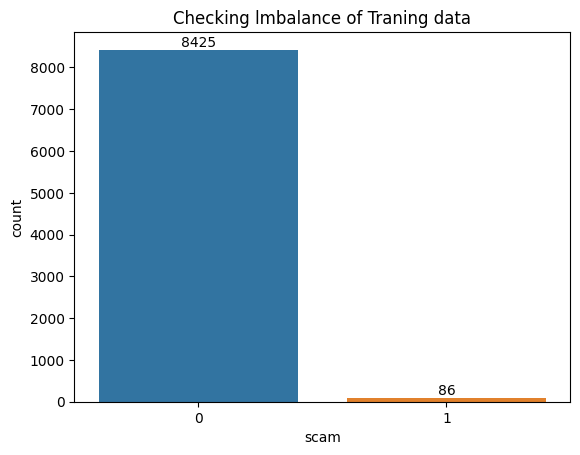

In [ ]:
check = pd.DataFrame({
    'id':y_train1,
    'scam':y_train1
})
smc = sns.countplot(data = check, x = 'scam')

for container in smc.containers:
    smc.bar_label(container)

plt.title('Checking lmbalance of Traning data')

Text(0.5, 1.0, 'Checking lmbalance of Traning data')

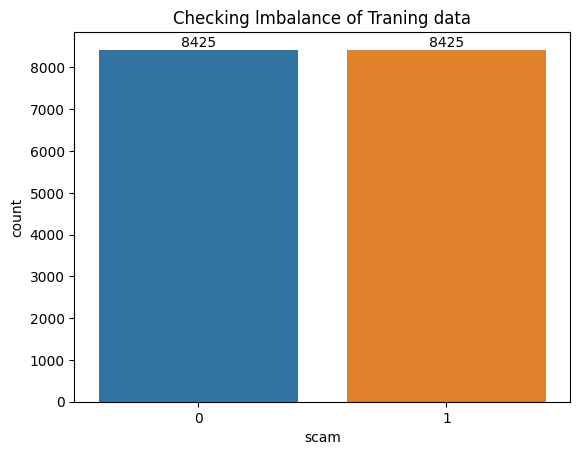

In [ ]:
#Optional
sm = SMOTE(k_neighbors=1)
enn = EditedNearestNeighbours(sampling_strategy='all',n_neighbors=3)

ada = SMOTEENN(smote=sm, enn=enn) #smote=sm, enn=enn
#ada = SMOTE(k_neighbors=1)

x_train, y_train = ada.fit_resample(x_train1, y_train1)

check = pd.DataFrame({
    'id':y_train,
    'scam':y_train
})
smc = sns.countplot(data = check, x = 'scam')

for container in smc.containers:
    smc.bar_label(container)

plt.title('Checking lmbalance of Traning data')

Text(0.5, 1.0, 'Checking lmbalance of Traning data')

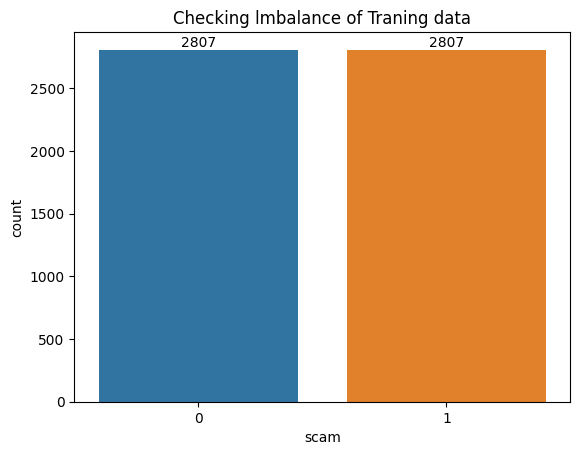

In [ ]:
x_val, y_val = ada.fit_resample(x_val1, y_val1)

check = pd.DataFrame({
    'id':y_val,
    'scam':y_val
})
smc = sns.countplot(data = check, x = 'scam')

for container in smc.containers:
    smc.bar_label(container)

plt.title('Checking lmbalance of Traning data')

In [ ]:
d_train = lgb.Dataset(x_train, label=y_train)
d_val = lgb.Dataset(x_val, label=y_val)

eval_set = [(d_train, 'train'), (d_val, 'valid')]

In [ ]:
lgbm = lgb.LGBMClassifier(objective='binary',n_jobs=-1)

param_grid = {
    'learning_rate': [0.01, 0.025, 0.05, 3e-4],
    'num_leaves': [30, 50, 100],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100],
    'max_depth': [-2, -1]
    }

'''
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }
'''

params = {'activation': 'relu',
          'objective': 'binary',
          'metric': 'binary_logloss',
          'learning_rate': 0.05,
          'num_leaves': 100,
          'reg_alpha': 0.1,
          'min_data_in_leaf': 30,
          'max_depth': -2
          }


#clf = SVC(C=100, gamma=1, kernel='rbf') #SVC()
#clf = GridSearchCV(lgbm, param_grid, n_jobs=-1, verbose=3)
#clf = clf.fit(x_train, y_train)

clf = lgb.train(params, d_train, num_boost_round=500, valid_sets=d_val, early_stopping_rounds=40)

#print(clf.best_params_)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: activation
[LightGBM] [Warning] Unknown parameter: activation
[LightGBM] [Info] Number of positive: 8425, number of negative: 8425
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 16850, number of used features: 128
[LightGBM] [Warning] Unknown parameter: activation
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's binary_logloss: 0.682527
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_logloss: 0.673493
[3]	valid_0's binary_logloss: 0.666348
[4]	valid_0's binary_logloss: 0.659992
[5]	valid_0's binary_logloss: 0.655106
[6]	valid_0's binary_logloss: 0.651076
[7]	valid_0's binary_logloss: 0.64757
[8]	valid_0's binary_logloss: 0.645073
[9]	valid_0's binary_logloss: 0.6

##Test

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:

threshold = 0.5
y_pred = (y_pred > threshold).astype(int)


              precision    recall  f1-score   support

    not scam     0.9938    0.8569    0.9203      2809
        scam     0.0337    0.4828    0.0629        29

    accuracy                         0.8531      2838
   macro avg     0.5137    0.6698    0.4916      2838
weighted avg     0.9840    0.8531    0.9115      2838



<Axes: >

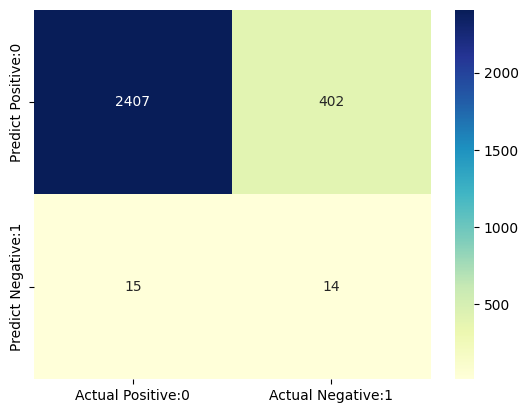

In [ ]:
target_names = ['not scam', 'scam']
cm = metrics.confusion_matrix(y_test, y_pred)
cm_dis = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'],
                                 index=['Predict Positive:0', 'Predict Negative:1'])

print(metrics.classification_report(y_test, y_pred, target_names=target_names, digits=4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))